# Comparison of Model Performances on Structured Functional Representation Task

In this notebook, I compare the several large language models' performance on a structured functional representation task using the Viggo dataset. 

The models evaluated include 
- GPT-4o
- Gemini 1.5 Flash
- Claude 3.5 Sonnet 
- LLaMA3 70B
- LLaMA3 8B
- Mistral 8x7B

The analysis focuses on four key metrics:

1. **Function Match**: The function name is the same, but the attributes and values can be different.
2. **Function Attribute Match**: The function and the attributes are the same, but the values can be different.
3. **Function Attributes Values Match**: The generated representation has the same function, attributes, and corresponding values, without requiring the same order of attributes and values.
4. **Exact Match**: The generated representation is exactly the same as the ground truth representation.

- These metrics are calculated by comparing the generated structured functional representations with the ground truth representations from the Viggo dataset's attributes column. 
- They provide a hierarchical view of how closely each model's output aligns with the expected structure and content.

> Note, I assume I already have the evaluated responses for all the models in the dict format(keys: `text`, `output`, `ground_truth`). 
>
> Please use to generate the responses for all the models `evaluate_models_viggo_val.ipynb` notebook 


In [18]:
# Import necessary libraries
import os
import json
import re
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import numpy as np

## Utility functions
To processing text data, calculating evaluation scores and plot and compare the results


In [19]:
def text_to_dict(text, attribute_class):
    """
    Convert a structured text representation to a dictionary.
    
    Args:
    text (str): The input text to convert
    attribute_class (str): The attribute class to remove from the text
    
    Returns:
    dict: A dictionary representation of the input text
    """
    # Remove attribute class and strip whitespace
    text = re.sub(attribute_class, "", text).strip()
    text = text[1:-1].strip() # remove the first and last bracket
    
    # Define the regex pattern to match key-value pairs
    pattern = r'(\w+)\[([^\]]+)\]'
    
    # Find all matches in the text
    matches = re.findall(pattern, text)
    
    # Convert matches to a dictionary, splitting values by comma and stripping whitespace
    result_dict = {key: [v.strip() for v in value.split(',')] for key, value in matches}
    
    return result_dict

def extract_function_name(text):
    """
    Extract the function name from a text string.
    
    Args:
    text (str): The input text
    
    Returns:
    str: The extracted function name
    """
    return text.split('(')[0]

def calculate_scores(responses_dict: dict):
    """
    Calculate evaluation scores for model responses.
    
    Args:
    responses_dict (dict): Dictionary containing model responses and ground truth
    
    Returns:
    tuple: A tuple containing two dictionaries (scores, avg_scores)
    """
    
    score_function_name_match = []
    score_function_attribute_match = []
    exact_match = []
    score_function_attribute_values_match = []

    for i, (k,v) in enumerate(responses_dict.items()):
        ground_truth = v['ground_truth']
        output = v['output']
        if output.startswith("Output:"): output = output.replace("Output:", "") # in llama3 models, tendency to start with "Output:"
        
        output = output.strip().lower() # remove \n from the end
        ground_truth = ground_truth.strip().lower()

        # Extract the function name
        ground_truth_fn_name = extract_function_name(ground_truth)
        output_fn_name = extract_function_name(output)
        
        # Extract the attributes and corresponding values
        ground_truth_attributes_classes = text_to_dict(ground_truth, ground_truth_fn_name)
        output_attributes_classes = text_to_dict(output, output_fn_name)
        
        # Calculate scores for different metrics
        exact_match.append(ground_truth == output)
        
        if ground_truth_fn_name == output_fn_name:
            score_function_name_match.append(True)
            
            if ground_truth_attributes_classes.keys() == output_attributes_classes.keys():
                score_function_attribute_match.append(True)
                
                score_value = all(set(ground_truth_attributes_classes[key]) == set(output_attributes_classes[key]) 
                                  for key in ground_truth_attributes_classes.keys())
                score_function_attribute_values_match.append(score_value)
            else:
                score_function_attribute_match.append(False)
                score_function_attribute_values_match.append(False)
        else:
            score_function_name_match.append(False)
            score_function_attribute_match.append(False)
            score_function_attribute_values_match.append(False)
    
    # Compile scores and calculate averages
    scores = {
        "exact_match": exact_match,
        "function_name_match": score_function_name_match,
        "function_attribute_match": score_function_attribute_match,
        "function_attribute_values_match": score_function_attribute_values_match
    }
        
    avg_scores = {key: sum(value)/len(value) for key, value in scores.items()}
    
    return scores, avg_scores

def plot_all_model_performance(results_df):
    """
    Create a single bar plot for all metrics across all models.
    X-axis shows evaluation scores, and legends represent models.
    
    Args:
    results_df (DataFrame): DataFrame containing all model results
    
    Returns:
    matplotlib.figure.Figure: The created plot figure
    """
    fig, ax = plt.subplots(figsize=(16, 10))
    
    # reorder the columns
    results_df = results_df[['exact_match', 'function_name_match', 'function_attribute_match', 'function_attribute_values_match']]
    
    # Transpose the DataFrame so that metrics are columns
    results_df_t = results_df.T
    
    # Plot bars for each model
    bar_width = 0.15
    index = np.arange(len(results_df_t.index))
    for i, model in enumerate(results_df_t.columns):
        ax.bar(index + i*bar_width, results_df_t[model], bar_width, label=model)
    
    ax.set_xlabel('Evaluation Metrics', fontsize=18, labelpad=10)
    ax.set_ylabel('Score', fontsize=18)
    ax.set_title('Model Performance Across Evaluation Metrics', fontsize=20, fontweight='bold')
    
    # Set x-ticks and labels with more space
    ax.set_xticks(index + bar_width * (len(results_df_t.columns) - 1) / 2)
    ax.set_xticklabels(results_df_t.index, rotation=0, ha='center', fontsize=15)
    ax.tick_params(axis='x', which='major', pad=0)  # Add padding below x-axis labels
    
    ax.tick_params(axis='y', labelsize=16)
    
    # Add legend inside the plot
    ax.legend(title='Models', title_fontsize='16', fontsize='14', loc='upper left', bbox_to_anchor=(0.01, 0.99))
    
    plt.tight_layout()
    
    return fig


## Set up the model names, file paths, and directories for the evaluation.

In [20]:
# List of models to evaluate
model_names = ['gpt-4o', 'gemini-1.5-flash', 'sonnet-3.5', 'llama3-70B', 'llama3-8B', 'mistral-8X7B']

# File and directory configurations
suffix = '_responses_viggo_val.json'
responses_dir = 'responses'
out_dir = '.'
out_plot_dir = f'{out_dir}/plots'

## Evaluate and compare the performance of all models.


In [21]:
# Evaluate all models
all_results = {}

for model_name in model_names:
    responses_path = f'{responses_dir}/{model_name}{suffix}'
    # Read JSON file
    with open(responses_path, "r") as f: responses_dict = json.load(f)
    # Calculate scores
    _, avg_scores = calculate_scores(responses_dict)
    # Store the results
    all_results[model_name] = avg_scores

# Create a DataFrame from the results
results_df = pd.DataFrame(all_results).T


# Display the results table, rounding to 2 decimal places
print("\nModel Performance Results:")
print(results_df.round(2).to_string())

    


Model Performance Results:
                  exact_match  function_name_match  function_attribute_match  function_attribute_values_match
gpt-4o                   0.30                 0.80                      0.72                             0.43
gemini-1.5-flash         0.14                 0.72                      0.57                             0.29
sonnet-3.5               0.32                 0.85                      0.74                             0.48
llama3-70B               0.12                 0.64                      0.49                             0.24
llama3-8B                0.05                 0.46                      0.22                             0.12
mistral-8X7B             0.06                 0.54                      0.26                             0.15


##  Visualization the Results
Creates bar charts to compare the performance of different models across evaluation metrics.


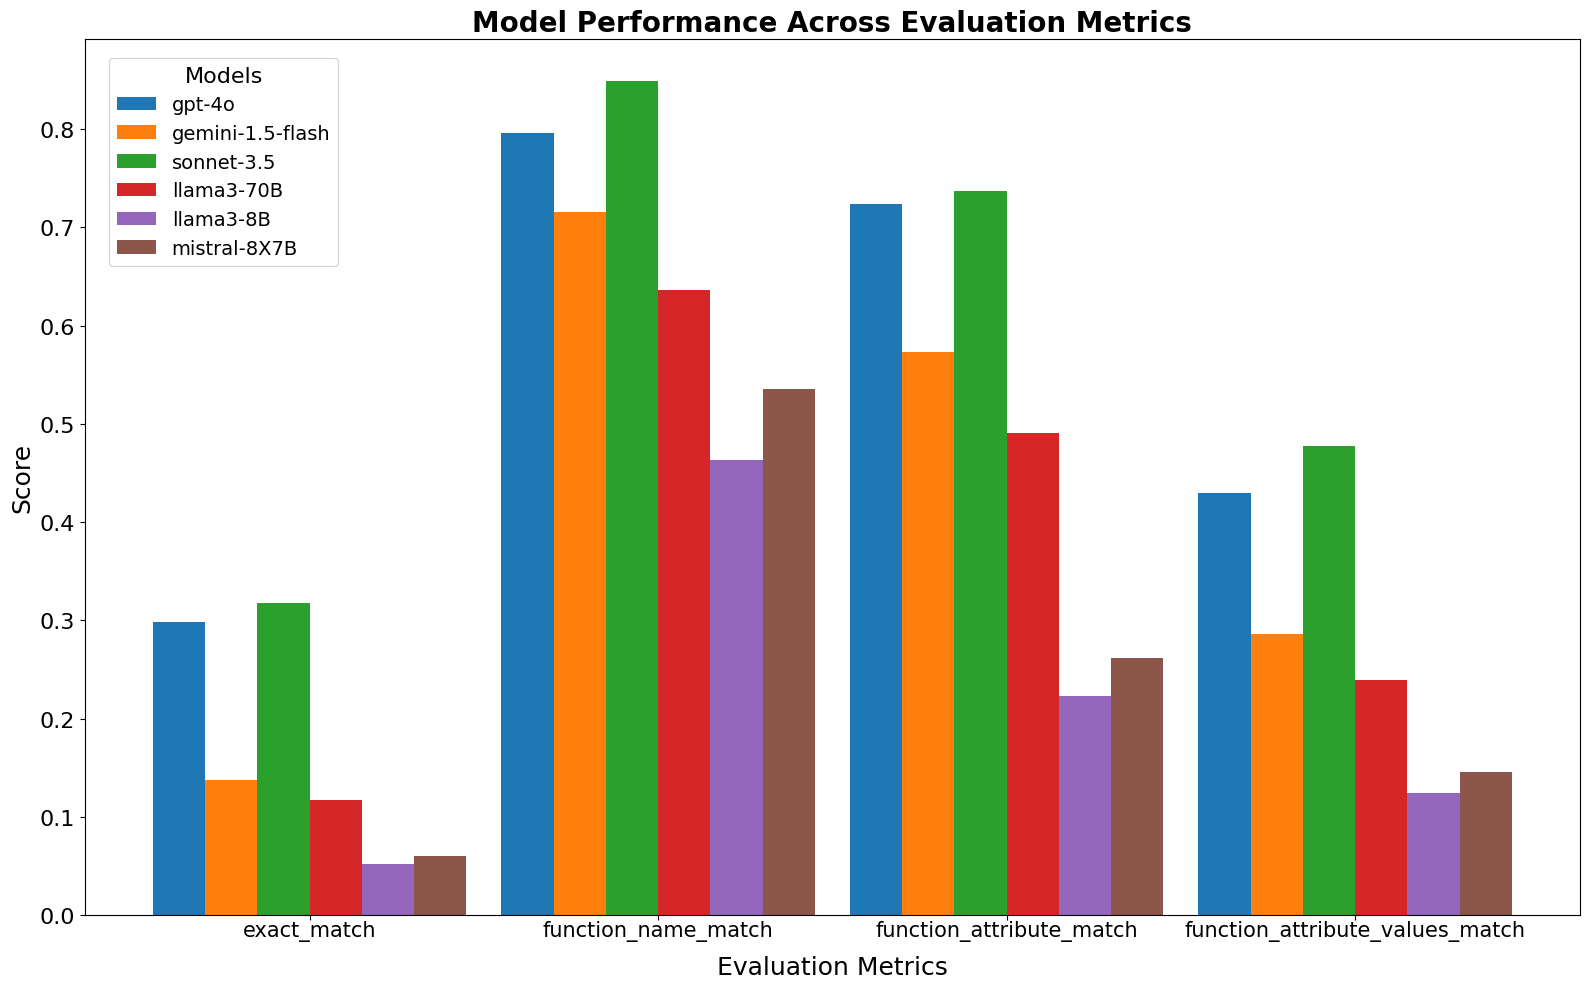

In [22]:
for model_name in model_names:
    responses_path = f'{responses_dir}/{model_name}{suffix}'
    with open(responses_path, "r") as f:
        responses_dict = json.load(f)
    _, avg_scores = calculate_scores(responses_dict)
    all_results[model_name] = avg_scores


# Plot all metrics for all models and get the figure
fig = plot_all_model_performance(results_df)

# Display the plot (optional)
plt.show()

# Save the figure
fig.savefig(f"{out_plot_dir}/all_metrics_comparison.png", dpi=300, bbox_inches='tight')

# Close the figure to free up memory
plt.close(fig)